# Day 2: Risk Measures & VaR
## Week 5: Portfolio Optimization

---

**Learning Objectives:**
- Understand Value at Risk (VaR) and Expected Shortfall (ES)
- Implement parametric, historical, and Monte Carlo VaR
- Learn risk budgeting and contribution
- Compare risk measures

In [1]:
# Day 2 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

TRADING_DAYS = 252

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)

assets = ['AAPL', 'MSFT', 'JPM', 'XOM', 'GLD', 'TLT']
prices = df[assets].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("RISK MEASURES & VAR - DAY 2")
print("=" * 60)

RISK MEASURES & VAR - DAY 2


## 1. Value at Risk (VaR)

**VaR** answers: "What is the maximum loss over a given time period at a given confidence level?"

- 95% VaR: We expect losses to exceed this only 5% of the time

In [2]:
# Create portfolio
print("=" * 60)
print("PORTFOLIO SETUP")
print("=" * 60)

# Equal weight portfolio
weights = np.array([1/len(assets)] * len(assets))
portfolio_value = 1_000_000  # $1M portfolio

# Portfolio returns
port_returns = returns.dot(weights)

print(f"\nPortfolio Statistics:")
print(f"  Mean Daily Return: {port_returns.mean():.4%}")
print(f"  Daily Volatility: {port_returns.std():.4%}")
print(f"  Annualized Return: {port_returns.mean() * TRADING_DAYS:.2%}")
print(f"  Annualized Volatility: {port_returns.std() * np.sqrt(TRADING_DAYS):.2%}")

PORTFOLIO SETUP

Portfolio Statistics:
  Mean Daily Return: 0.0787%
  Daily Volatility: 0.9674%
  Annualized Return: 19.84%
  Annualized Volatility: 15.36%


In [3]:
# Three methods to calculate VaR
print("=" * 60)
print("VALUE AT RISK (VaR) METHODS")
print("=" * 60)

confidence_level = 0.95
alpha = 1 - confidence_level

# Method 1: Parametric (Normal) VaR
mu = port_returns.mean()
sigma = port_returns.std()
z_score = stats.norm.ppf(alpha)
parametric_var = -(mu + z_score * sigma)

print(f"\n📊 Method 1: Parametric (Normal) VaR")
print(f"  Assumption: Returns ~ N({mu:.6f}, {sigma:.6f})")
print(f"  Z-score at {alpha:.0%}: {z_score:.4f}")
print(f"  1-Day {confidence_level:.0%} VaR: {parametric_var:.4%}")
print(f"  Dollar VaR: ${portfolio_value * parametric_var:,.0f}")

# Method 2: Historical VaR
historical_var = -port_returns.quantile(alpha)

print(f"\n📊 Method 2: Historical VaR")
print(f"  No distributional assumption")
print(f"  1-Day {confidence_level:.0%} VaR: {historical_var:.4%}")
print(f"  Dollar VaR: ${portfolio_value * historical_var:,.0f}")

# Method 3: Monte Carlo VaR
n_simulations = 10000
simulated_returns = np.random.normal(mu, sigma, n_simulations)
mc_var = -np.percentile(simulated_returns, alpha * 100)

print(f"\n📊 Method 3: Monte Carlo VaR")
print(f"  Simulations: {n_simulations:,}")
print(f"  1-Day {confidence_level:.0%} VaR: {mc_var:.4%}")
print(f"  Dollar VaR: ${portfolio_value * mc_var:,.0f}")

VALUE AT RISK (VaR) METHODS

📊 Method 1: Parametric (Normal) VaR
  Assumption: Returns ~ N(0.000787, 0.009674)
  Z-score at 5%: -1.6449
  1-Day 95% VaR: 1.5124%
  Dollar VaR: $15,124

📊 Method 2: Historical VaR
  No distributional assumption
  1-Day 95% VaR: 1.3278%
  Dollar VaR: $13,278

📊 Method 3: Monte Carlo VaR
  Simulations: 10,000
  1-Day 95% VaR: 1.5221%
  Dollar VaR: $15,221


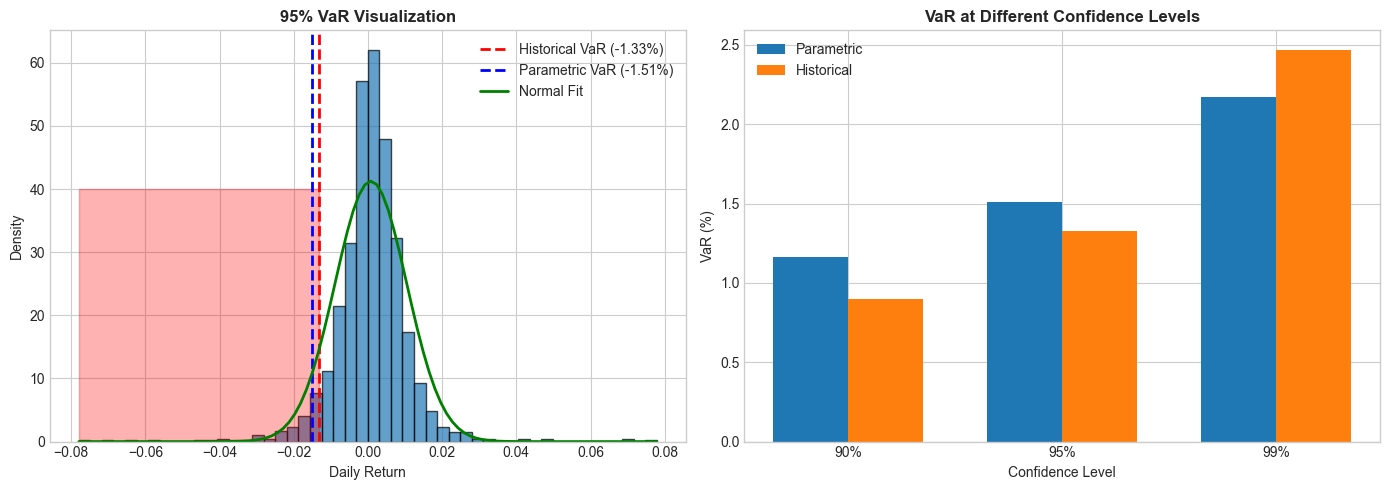


VaR Comparison:
Confidence  Parametric  Historical
       90%    0.011610    0.008994
       95%    0.015124    0.013278
       99%    0.021717    0.024683


In [4]:
# Visualize VaR
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Historical distribution
axes[0].hist(port_returns, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0].axvline(-historical_var, color='red', linestyle='--', linewidth=2, 
                label=f'Historical VaR ({-historical_var:.2%})')
axes[0].axvline(-parametric_var, color='blue', linestyle='--', linewidth=2,
                label=f'Parametric VaR ({-parametric_var:.2%})')

# Overlay normal distribution
x = np.linspace(port_returns.min(), port_returns.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'g-', linewidth=2, label='Normal Fit')

axes[0].fill_betweenx([0, 40], port_returns.min(), -historical_var, alpha=0.3, color='red')
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Density')
axes[0].set_title(f'{confidence_level:.0%} VaR Visualization', fontweight='bold')
axes[0].legend()

# VaR at different confidence levels
confidence_levels = [0.90, 0.95, 0.99]
var_comparison = []

for cl in confidence_levels:
    a = 1 - cl
    var_comparison.append({
        'Confidence': f'{cl:.0%}',
        'Parametric': -(mu + stats.norm.ppf(a) * sigma),
        'Historical': -port_returns.quantile(a)
    })

var_df = pd.DataFrame(var_comparison)
x_pos = np.arange(len(confidence_levels))
width = 0.35

axes[1].bar(x_pos - width/2, var_df['Parametric'] * 100, width, label='Parametric')
axes[1].bar(x_pos + width/2, var_df['Historical'] * 100, width, label='Historical')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(var_df['Confidence'])
axes[1].set_xlabel('Confidence Level')
axes[1].set_ylabel('VaR (%)')
axes[1].set_title('VaR at Different Confidence Levels', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nVaR Comparison:")
print(var_df.to_string(index=False))

## 2. Expected Shortfall (CVaR)

**Expected Shortfall** (Conditional VaR): Average loss given that loss exceeds VaR

In [5]:
# Expected Shortfall
print("=" * 60)
print("EXPECTED SHORTFALL (CVaR)")
print("=" * 60)

def calculate_es(returns, confidence_level=0.95):
    """Calculate Expected Shortfall (CVaR)."""
    alpha = 1 - confidence_level
    var = -returns.quantile(alpha)
    es = -returns[returns <= -var].mean()
    return var, es

# Historical ES
var_95, es_95 = calculate_es(port_returns, 0.95)
var_99, es_99 = calculate_es(port_returns, 0.99)

print(f"\n📊 95% Confidence:")
print(f"  VaR: {var_95:.4%} (${portfolio_value * var_95:,.0f})")
print(f"  ES:  {es_95:.4%} (${portfolio_value * es_95:,.0f})")

print(f"\n📊 99% Confidence:")
print(f"  VaR: {var_99:.4%} (${portfolio_value * var_99:,.0f})")
print(f"  ES:  {es_99:.4%} (${portfolio_value * es_99:,.0f})")

# Parametric ES (for normal distribution)
def parametric_es(mu, sigma, confidence_level=0.95):
    alpha = 1 - confidence_level
    var = -(mu + stats.norm.ppf(alpha) * sigma)
    es = -mu + sigma * stats.norm.pdf(stats.norm.ppf(alpha)) / alpha
    return var, es

p_var, p_es = parametric_es(mu, sigma, 0.95)
print(f"\n📊 Parametric ES (95%):")
print(f"  VaR: {p_var:.4%}")
print(f"  ES:  {p_es:.4%}")

EXPECTED SHORTFALL (CVaR)

📊 95% Confidence:
  VaR: 1.3278% ($13,278)
  ES:  2.2128% ($22,128)

📊 99% Confidence:
  VaR: 2.4683% ($24,683)
  ES:  4.0655% ($40,655)

📊 Parametric ES (95%):
  VaR: 1.5124%
  ES:  1.9166%


## 3. Risk Contribution

RISK CONTRIBUTION

Portfolio Volatility: 15.36%

📊 Risk Contribution Analysis:
Asset   Weight  Marginal RC  Risk Contribution      RC %
 AAPL 0.166667     0.243433           0.040572  0.264207
 MSFT 0.166667     0.214393           0.035732  0.232688
  JPM 0.166667     0.216977           0.036163  0.235492
  XOM 0.166667     0.205049           0.034175  0.222547
  GLD 0.166667     0.043193           0.007199  0.046879
  TLT 0.166667    -0.001670          -0.000278 -0.001812


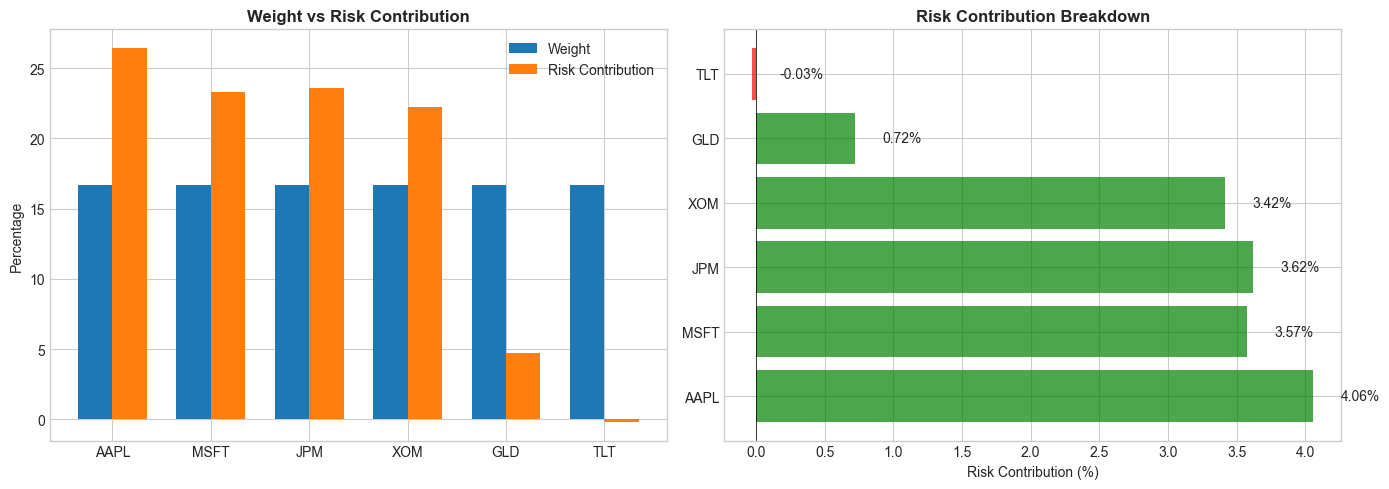

In [7]:
# Risk contribution analysis
print("=" * 60)
print("RISK CONTRIBUTION")
print("=" * 60)

cov_matrix = returns.cov() * TRADING_DAYS

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def marginal_risk_contribution(weights, cov_matrix):
    """Calculate marginal risk contribution of each asset."""
    port_vol = portfolio_volatility(weights, cov_matrix)
    return np.dot(cov_matrix, weights) / port_vol

def risk_contribution(weights, cov_matrix):
    """Calculate risk contribution of each asset."""
    mrc = marginal_risk_contribution(weights, cov_matrix)
    return weights * mrc

# Calculate for equal weight portfolio
port_vol = portfolio_volatility(weights, cov_matrix)
mrc = marginal_risk_contribution(weights, cov_matrix)
rc = risk_contribution(weights, cov_matrix)

print(f"\nPortfolio Volatility: {port_vol:.2%}")
print(f"\n📊 Risk Contribution Analysis:")

rc_df = pd.DataFrame({
    'Asset': assets,
    'Weight': weights,
    'Marginal RC': mrc,
    'Risk Contribution': rc,
    'RC %': rc / rc.sum()
})
print(rc_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weight vs Risk Contribution
x = np.arange(len(assets))
width = 0.35

axes[0].bar(x - width/2, weights * 100, width, label='Weight')
axes[0].bar(x + width/2, (rc / rc.sum()) * 100, width, label='Risk Contribution')
axes[0].set_xticks(x)
axes[0].set_xticklabels(assets)
axes[0].set_ylabel('Percentage')
axes[0].set_title('Weight vs Risk Contribution', fontweight='bold')
axes[0].legend()

# Bar chart of risk contribution (handles negative values better than pie)
colors = ['green' if v >= 0 else 'red' for v in rc]
axes[1].barh(assets, rc * 100, color=colors, alpha=0.7)
axes[1].axvline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Risk Contribution (%)')
axes[1].set_title('Risk Contribution Breakdown', fontweight='bold')
for i, (asset, val) in enumerate(zip(assets, rc)):
    axes[1].text(val * 100 + 0.2, i, f'{val:.2%}', va='center')

plt.tight_layout()
plt.show()

## 4. Risk Parity Portfolio

In [8]:
# Risk parity optimization
print("=" * 60)
print("RISK PARITY PORTFOLIO")
print("=" * 60)

def risk_parity_objective(weights, cov_matrix):
    """Objective: minimize deviation from equal risk contribution."""
    n = len(weights)
    rc = risk_contribution(weights, cov_matrix)
    target_rc = portfolio_volatility(weights, cov_matrix) / n
    
    # Sum of squared deviations from target
    return np.sum((rc - target_rc) ** 2)

# Optimize
n_assets = len(assets)
initial_weights = np.array([1/n_assets] * n_assets)

constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0.01, 1) for _ in range(n_assets))

result = minimize(
    risk_parity_objective,
    initial_weights,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

rp_weights = result.x
rp_rc = risk_contribution(rp_weights, cov_matrix)

print(f"\n📊 Risk Parity Portfolio:")
rp_df = pd.DataFrame({
    'Asset': assets,
    'Weight': rp_weights,
    'Risk Contribution': rp_rc,
    'RC %': rp_rc / rp_rc.sum()
})
print(rp_df.to_string(index=False))

print(f"\nPortfolio Volatility: {portfolio_volatility(rp_weights, cov_matrix):.2%}")

# Compare to equal weight
print(f"\n📊 Comparison:")
print(f"  Equal Weight Vol: {portfolio_volatility(weights, cov_matrix):.2%}")
print(f"  Risk Parity Vol: {portfolio_volatility(rp_weights, cov_matrix):.2%}")

RISK PARITY PORTFOLIO

📊 Risk Parity Portfolio:
Asset   Weight  Risk Contribution     RC %
 AAPL 0.093207           0.018632 0.163861
 MSFT 0.107151           0.018993 0.167036
  JPM 0.114865           0.018949 0.166650
  XOM 0.115850           0.019196 0.168816
  GLD 0.241441           0.019161 0.168510
  TLT 0.327486           0.018776 0.165127

Portfolio Volatility: 11.37%

📊 Comparison:
  Equal Weight Vol: 15.36%
  Risk Parity Vol: 11.37%


## 📝 Key Takeaways - Day 2

### VaR Methods:
| Method | Pros | Cons |
|--------|------|------|
| Parametric | Fast, simple | Assumes normality |
| Historical | No assumptions | Limited by history |
| Monte Carlo | Flexible | Computationally intensive |

### VaR vs ES:
- **VaR**: "What's the worst that can happen (at confidence level)?" 
- **ES**: "If things go bad, how bad?" (more conservative)

### Risk Parity:
- Each asset contributes equally to portfolio risk
- Typically leads to higher bond allocation
- More diversified risk exposure

### Interview Questions:
- "Explain the difference between VaR and Expected Shortfall"
- "What are the limitations of VaR?"
- "What is a risk parity portfolio?"